In [16]:
import pandas as pd
import numpy as np
import quantstats as qs
import volatility_arb as va

import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('_omxs30_data.csv', header=0, index_col=0, parse_dates=True)

## Model Setup

In [18]:
spot = data["spot"].dropna()
riskfree_rate = data["yield"].dropna()
invest_rate = data["stibor"].dropna()
implied_vol = data["1m_iv"]
implied_vol_3m = data['3m_iv']
dividends = 0.0

rets = data["return"]
rets = rets.dropna()
rets = rets[rets != 0]
start = rets.index[0]
end = rets.index[-1]

In [19]:
match_imp_vol = implied_vol.reindex(spot.index)
real_var = va.variance_forecast(rets, start, end, dist='studentst')
path = va.short_straddle_path(spot, match_imp_vol, riskfree_rate, dividends, market='Sweden')

In [20]:
real_vol = np.sqrt(real_var)
spread = implied_vol - real_vol.dropna()
ratio = implied_vol / real_vol

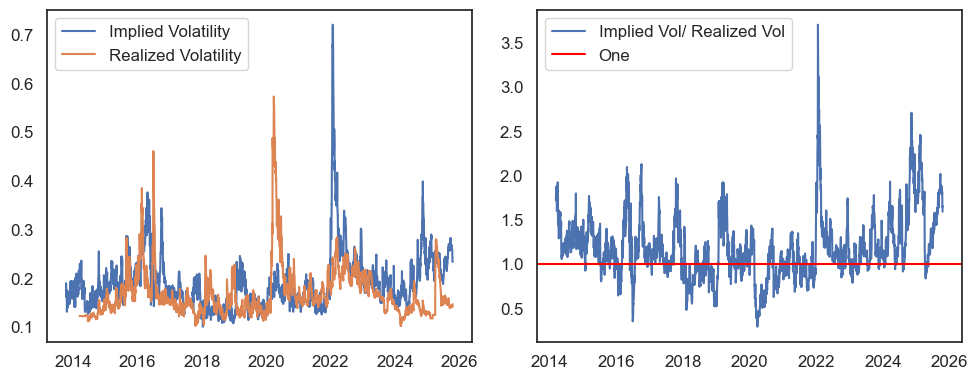

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(implied_vol, ax=ax[0], label="Implied Volatility")
sns.lineplot(real_vol, ax=ax[0], label="Realized Volatility")
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.lineplot(ratio, ax=ax[1], label="Implied Vol/ Realized Vol")
ax[1].axhline(1, color='red', label='One')
ax[1].set_xlabel('')
ax[1].legend()
fig.tight_layout()
plt.show()

## Trading Delta-Hedged Short Straddles Rolling Monthly

In [33]:
score = va.volscore(implied_vol, implied_vol_3m, spread)
strategy = va.short_straddle_strategy_delta_hedged(path, score, invest_rate)
strategy_rets = strategy['NAV'].pct_change()
qs.reports.metrics(strategy_rets, benchmark=rets, match_dates=True, mode='full')

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-10-21   2015-10-21
End Period                 2025-10-17   2025-10-17
Risk-Free Rate             0.0%         0.0%
Time in Market             98.0%        96.0%

Cumulative Return          86.83%       36.8%
CAGR﹪                     6.33%        3.12%

Sharpe                     0.44         1.48
Prob. Sharpe Ratio         91.63%       99.99%
Smart Sharpe               0.42         1.44
Sortino                    0.61         1.89
Smart Sortino              0.59         1.84
Sortino/√2                 0.43         1.34
Smart Sortino/√2           0.42         1.3
Omega                      1.47         1.47

Max Drawdown               -31.99%      -11.13%
Max DD Date                2020-03-23   2022-01-20
Max DD Period Start        2020-02-20   2019-07-17
Max DD Period End          2020-11-10   2023-06-07
Longest DD Days            786          1422
Volati